In [5]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

from plotnine import *

import pickle

%run -i 'model_helpers.py'
%run -i 'models.py'
%run -i 'reloo-compare.py'

In [6]:
def load_data_exp2_trials():
    df = load_raw_data(2)
    
    df["condition"] = np.select(
    [
        df.querydetail.str.contains("windy|cloudy"), 
        df.querydetail.str.contains("cold|rainy"),
        df.querydetail.str.contains("warm|snowy")

    ], 
    [
        0,
        1,
        2
    ], 
    default=0 )
    
    original_ids = list(np.unique(df.ID))
    fix_id_dict = {original_ids[i]:i for i in range(0, len(original_ids))}
    
    df = df.assign(ID = df.ID.apply(lambda x: fix_id_dict[x]))

    return df


# >>
#         s.mutate(estimate =  _.estimate.replace({0:.01, 1:.99}))

In [7]:
df = load_data_exp2_trials() # see data_helpers.py
df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
# df = df.sort_values(by=["ID","block","condition"]) # don't think I need to sort?

df = (df >> 
      # s.mutate(block = _.block-1) >> 
      # s.filter(_.block==1) >>
      # s.group_by(_.ID, _.condition, _.querytype, _.querydetail) >> 
      # s.summarize(estimate = _.estimate.mean()) >>
      s.mutate(estimate =  _.estimate.replace({0:.01, 1:.99}))
     )

df.head(20)


,ID,block,trial,query,querydetail,querytype,estimate,starttime,endtime,RT,condition
2,0,1,3,If the weather in England is cloudy on a rando...,windy given cloudy,AgB,0.80,76763.706192,76772.946467,9.240275,0
3,0,1,4,If the weather in England is windy on a random...,not cloudy given windy,notBgA,0.40,76773.072750,76782.666277,9.593527,0
4,0,1,5,What is the probability that the weather will ...,cold and rainy,AandB,0.70,76782.789357,76794.954048,12.164691,1
8,0,1,9,What is the probability that the weather will ...,not windy or not cloudy,notAornotB,0.75,76847.388571,76878.392191,31.003619,0
9,0,1,10,What is the probability that the weather will ...,windy and cloudy,AandB,0.70,76878.521995,76895.023852,16.501857,0
11,0,1,12,If the weather in England is cold on a random ...,rainy given cold,BgA,0.80,76918.304703,76931.087126,12.782424,1
12,0,1,13,What is the probability that the weather will ...,windy or not cloudy,AornotB,0.90,76931.187936,76955.526714,24.338778,0
15,0,1,16,What is the probability that the weather will ...,cloudy,B,0.90,76991.854123,76996.278082,4.423960,0
16,0,1,17,What is the probability that the weather will ...,rainy or not cold,notAorB,0.80,76996.437433,77012.973403,16.535970,1
19,0,1,20,What is the probability that the weather will ...,rainy,B,0.70,77035.020481,77045.060781,10.040300,1


In [8]:

(
    df >> s.group_by("ID") >> 
    s.summarize(min_resp = _.estimate.min(), max_resp = 1-_.estimate.max()) >>
    s.gather("var", "val", _.min_resp, _.max_resp) >>
    s.group_by("ID") >>
    s.summarize(max_d = _.val.min())
) >> s.ungroup() >> s.count(_.max_d)


,max_d,n
0,0.01,9
1,0.01,6
2,0.02,4
3,0.02,1
4,0.03,9
5,0.03,2
6,0.04,11
7,0.05,8
8,0.05,1
9,0.07,1


In [9]:
X_data, y_data = make_model_data(df) # see data_helpers.py

print(len(y_data), "observations")

10080 observations


In [10]:
X_data

{'trial': 2               AgB
 3            notBgA
 4             AandB
 8        notAornotB
 9             AandB
             ...    
 15107          AorB
 15111             B
 15112        AgnotB
 15115        BgnotA
 15116           BgA
 Name: querytype, Length: 10080, dtype: object,
 'subj': DeviceArray([ 0,  0,  0, ..., 83, 83, 83], dtype=int32),
 'cond': DeviceArray([0, 0, 1, ..., 0, 1, 1], dtype=int32)}

# Bayesian sampler model

Here I implement the Bayesian Sampler model as expressed in the Zhu et al. (2020) paper. The only difference is I parameterize it directly in terms of implied $d$ so that it can be more fairly compared with the PT+N model. 

## Simple

First, I implement the simple model with only one $d$ value for each participant. Here implied $d \in [0,\frac{1}{3}]$, reflecting the class of "ignorance priors" for the underlying Bayesian Sampler model.

In [5]:
## -------------------------------------
## Bayesian Sampler
## -------------------------------------

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


def bayesian_sampler_simple(data, y=None):

    # Data processing
    trial, subj, cond= data["trial"], data["subj"], data["cond"]#, data["block"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]#, np.unique(block).shape[0]
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
#    with numpyro.plate("subj", n_Ps):
#        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#        Ns = numpyro.sample("N_prime", dist.Normal(0,3))

    with numpyro.plate("subj", n_Ps):
#        ds = numpyro.sample("d_base", dist.Beta(1, 1))
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors (vary by subject and query but not block)
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
#    N_lin = Ns[subj] #  < --------------     
#    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat



In [106]:
kernel_bs_simple = NUTS(bayesian_sampler_simple, target_accept_prob=.80)

mcmc_bs_simple = MCMC(kernel_bs_simple, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [110]:
# mcmc_bs_simple.print_summary()

Participant mean response corr =  0.549
Query-level corr 0.844


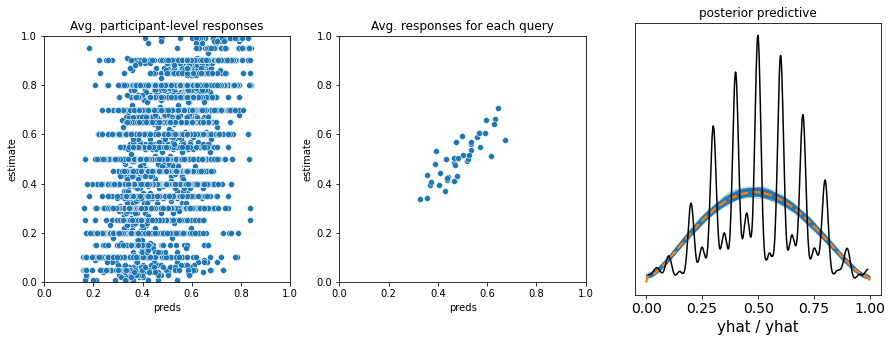

In [108]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_simple)

In [11]:
loo_bs_simple = model_reloo(mcmc_bs_simple, kernel_bs_simple, k_thresh=.70)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [12]:
# pickle.dump(az_data_bs_simple, open("local/exp2/az_data_bs_simple.p", "wb"))
# pickle.dump(loo_bs_simple, open("local/exp2/loo_bs_simple.p", "wb"))

## Parameterized in terms of $\beta$ and $N$

Now parameterized as needed for modeling dispersion.

N and beta are going to be potentially very highly correlated here. -- fortunately it sampled with no divergences!

In [113]:
def bayesian_sampler_simple2(data, y=None):

    # Data processing
    trial, subj, cond= data["trial"], data["subj"], data["cond"]#, data["block"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]#, np.unique(block).shape[0]
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
#    with numpyro.plate("subj", n_Ps):
#        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#        Ns = numpyro.sample("N_prime", dist.Normal(0,3))

    with numpyro.plate("subj", n_Ps):
#        ds = numpyro.sample("d_base", dist.Beta(1, 1))
        # ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        betas = numpyro.sample("beta_base", dist.Beta(1,1))
        Ns = numpyro.sample("N_base", dist.HalfCauchy(10))
        
    # subject/query-level parameters/priors (vary by subject and query but not block)
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    # d_lin = ds[subj]
    N = 1. + Ns[subj]
    beta = betas[subj]
    # d = sigmoid(d_lin)/3.
#    N_lin = Ns[subj] #  < --------------     
#    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat



In [114]:
kernel_bs_simple2 = NUTS(bayesian_sampler_simple2, target_accept_prob=.80)

mcmc_bs_simple2 = MCMC(kernel_bs_simple2, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_simple2.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [122]:
# mcmc_bs_simple2.print_summary()

Participant mean response corr =  0.548
Query-level corr 0.838


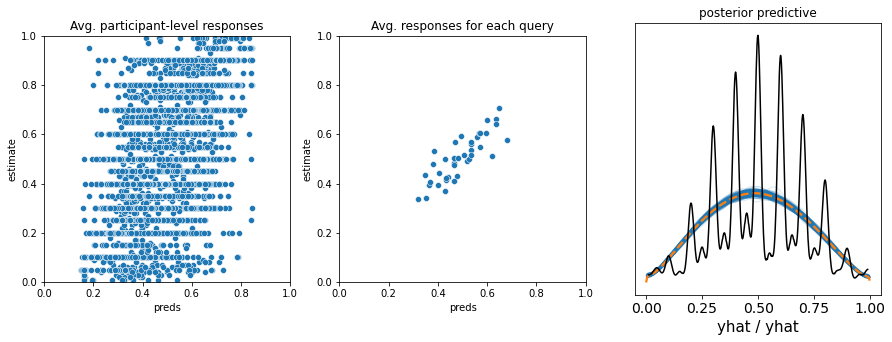

In [118]:
az_data_bs_simple2 = make_arviz_data(mcmc_bs_simple2, bayesian_sampler_simple2, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_simple2)

# Hierarchical Bayesian Sampler

Unpooled models may be overpenalized for complexity if the heterogenity among participants is actually low. Here I implement hierarchical versions of the PT+N and Bayesian Sampler models that impelement partial pooling. This allows for sharing of information and potentially reduced model complexity.


## Complex

Here's the complex version in its original parameterization

In [6]:
def bayesian_sampler_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2, 1)) # roughly uniform after summing with random effects + sigmoid()
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*10 # constrains beta to [0,10]
    #beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)

    return yhat

In [7]:
kernel_bs = NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.80)

mcmc_bs = MCMC(kernel_bs, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4
              )

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
# loo_bs = model_reloo(mcmc_bs, kernel_bs, k_thresh=.70)

# mcmc_bs.print_summary()

Participant mean response corr =  0.62
Query-level corr 0.845


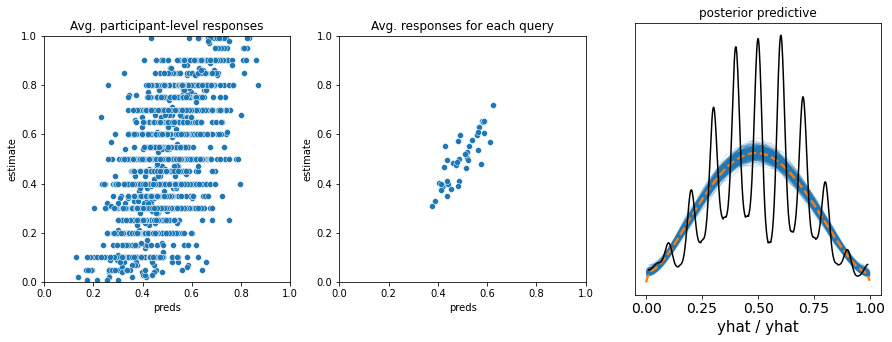

In [9]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
# pickle.dump(az_data_bs, open("local/exp2/az_data_bs.p", "wb"))
# pickle.dump(loo_bs, open("local/exp2/loo_bs.p", "wb"))
plot_model_preds(df, az_data_bs)

## Varying noise parameters



In [156]:
def prob_judge_BS2(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def bayesian_sampler_complex_mlm_noise(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*1 # constrains beta to [0,10]
    # beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    # p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta) 
    
    # new 6/20/22, 4:06 PM
    pi = calc_prob(theta, X_num, X_denom)
    
    # y_trans = jnp.clip((y*(N+2*beta)-beta)/N, .001, .999) # unconstrained can produce neg values
    
    # Nsd = numpyro.sample("Nsd", dist.LogNormal(0, 1))
    
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        # scale_transformed = .1
        # y_err = numpyro.sample("y_err", dist.Beta(1,1))
        # y_err = (y_err - .50)*scale_transformed
        # z = y + y_err
        
        # Ntrial = numpyro.sample("Ntrial", dist.Normal(0, 1))
        # N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

        yhat = numpyro.sample(
            "yhat",
            TransformedDistribution(
                dist.Beta(pi*N, (1-pi)*N), 
                AffineTransform(beta/(N+2*beta), N/(N+2*beta)),
                validate_args = True
            ),
            obs = y # can find valid inits if beta constrained to [0, 1]
        )

    return yhat



In [161]:
from numpyro.infer.initialization import init_to_sample, init_to_median, init_to_value

kernel_bs_noise = NUTS(
    bayesian_sampler_complex_mlm_noise, 
    target_accept_prob=.95,
    init_strategy = init_to_sample()
)

mcmc_bs_noise = MCMC(kernel_bs_noise, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_bs_noise.run(random.PRNGKey(12), X_data, y_data)

sample: 100%|██████████| 4000/4000 [52:24<00:00,  1.27it/s, 1023 steps of size 2.81e-06. acc. prob=0.87]


In [163]:
# mcmc_bs_noise.print_summary()

In [164]:
# .5*(10 + 2.*1)/10 - 2/10
# (y*(N+2*beta)-beta)/N
# isinstance(None, jax.numpy.ndarray)
# (.02*(10+2*1)-1)/10 # can make neg values

# def make_arviz_data(mcmc, model, ydata):
#     posterior_samples = mcmc.get_samples()

#     posterior_predictive = Predictive(model, posterior_samples)(
#         random.PRNGKey(1), *args
#     )
#     prior = Predictive(model, num_samples=500)(
#         random.PRNGKey(2), *args
#     )

#     return az.from_numpyro(
#         mcmc,
#         prior = prior,
#         posterior_predictive = posterior_predictive
#     )

def make_arviz_data(mcmc, model, data):
    posterior_samples = mcmc.get_samples()

    posterior_predictive = Predictive(model, posterior_samples)(
        random.PRNGKey(1), data
    )
    prior = Predictive(model, num_samples=500)(
        random.PRNGKey(2), data
    )

    return az.from_numpyro(
        mcmc,
        prior = prior,
        posterior_predictive = posterior_predictive
    )

divegences: 122
Participant mean response corr =  0.069
Query-level corr 0.257


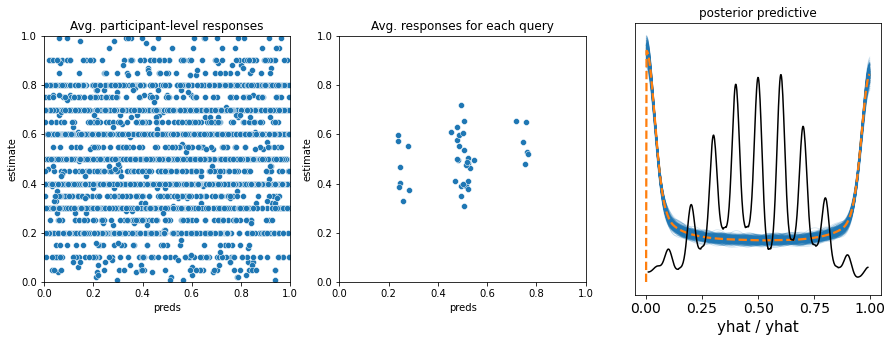

In [166]:
az_data_bs_noise = make_arviz_data(mcmc_bs_noise, bayesian_sampler_complex_mlm_noise, X_data) # see model_helpers.py
# pickle.dump(az_data_bs_noise, open("local/exp2/az_data_bs_noise.p", "wb"))
# pickle.dump(loo_bs, open("local/exp2/loo_bs.p", "wb"))
print("divegences:", count_divergences(az_data_bs_noise))
plot_model_preds(df, az_data_bs_noise)

In [121]:
from numpyro.distributions  import TransformedDistribution
from numpyro.distributions.transforms import AffineTransform

# TransformedDistribution(dist.Beta(1.,1.), AffineTransform(beta/(N+2*beta), N/(N+2*beta))).sample(random.PRNGKey(0),sample_shape=(10,))

TransformedDistribution(
                dist.Beta(.75*1, (1-.75)*1), 
                AffineTransform(1/(1+2*1), 1/(1+2*1)),
                validate_args = True
            ).sample(random.PRNGKey(0),sample_shape=(10,))

def bayesian_sampler_complex_mlm_noise_latentrnd(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*1 # constrains beta to [0,10]
    # beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    # p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta) 
    
    # new 6/20/22, 4:06 PM
    pi = calc_prob(theta, X_num, X_denom)
    
    # y_trans = jnp.clip((y*(N+2*beta)-beta)/N, .001, .999) # unconstrained can produce neg values
    
    # Nsd = numpyro.sample("Nsd", dist.LogNormal(0, 1))
    
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        
        # latent prob that gets transformed to p_bs
        
        # use that distribution to define category probs
        # plus a mixture to allow other responses (other rounding, "garbage")
        
        # yhat = numpyro.sample(
        #     "yhat",
        #     TransformedDistribution(
        #         dist.Beta(pi*N, (1-pi)*N), 
        #         AffineTransform(beta/(N+2*beta), N/(N+2*beta)),
        #         validate_args = True
        #     ),
        #     obs = y # can find valid inits if beta constrained to [0, 1]
        # )

    return yhat

DeviceArray([0.4205451 , 0.66666603, 0.6660234 , 0.5151983 , 0.6487895 ,
             0.66664356, 0.5845951 , 0.6088253 , 0.567842  , 0.3871107 ],            dtype=float32)

## Allowing individual noise params to freely vary

In [11]:
def bayesian_sampler_complex_mlm_noise_free(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-1, 1)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfNormal(1)) # dist.HalfCauchy(1)

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))
        ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    # beta = sigmoid(beta_pop + betas[subj])*3 # constrains beta to [0,10]
    beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    k = ks[subj]

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)

    return yhat


# def bs_complex_mlm_freenoise_d(data, y=None):
    
#     # parameterized in terms of d and d' for comparison of model fit

#     # Data processing
#     trial, subj, cond = data["trial"], data["subj"], data["cond"]
#     n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
#     # setup "design matrix" (of sorts)
#     X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
#     conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

#     # population level parameters/priors
#     # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

#     d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
#     d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
#     d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
#     d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

#     # subject-level parameters/priors 
#     with numpyro.plate("subj", n_Ps):
#         d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
#         d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
#         ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
        
#     # subject/query-level parameters/priors
#     with numpyro.plate("cond", n_Ps*n_conds):
#         thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#     d_lin = (d_base_pop + 
#              d_bases[subj]*d_base_sd + 
#              jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
#             )  # exp() constrains d_delta to be positive
#     d = sigmoid(d_lin)/3.0 # require this be in [0, 1/3]
    
#     numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/3.)
#     numpyro.deterministic("d_prime_subj", 
#                           sigmoid(d_base_pop + 
#                                   d_bases*d_base_sd + 
#                                   jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
#                                  )/3.
#                          )
    
#     theta_ind = ((subj*n_conds)+cond)
#     theta = thetas[theta_ind,:]
        
#     p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
#     k = ks[subj]
    
#     # Likelihood
#     with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
#     return yhat

def bs_complex_mlm_freenoise_d(data, y=None):
    
    # parameterized in terms of d and d' for comparison of model fit

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
    d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
    d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(1,.75)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(1,.75)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfNormal(1))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfNormal(1))
    
    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, 1))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, 1))
        # ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = (d_base_pop + 
             d_bases[subj]*d_base_sd + 
             jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
            )  # exp() constrains d_delta to be positive
    
    d = sigmoid(d_lin)/2.0 # require this be in [0, 1/3]
    
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]*N_prime_sd) + jnp.exp(N_delta_pop + N_deltas[subj]*N_delta_sd) * not_conjdisj # they also required N be at least 1
    
    numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/2.)
    numpyro.deterministic("d_prime_subj", 
                          sigmoid(d_base_pop + 
                                  d_bases*d_base_sd + 
                                  jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
                                 )/2.
                         )
    
    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes*N_prime_sd) + jnp.exp(N_delta_pop + N_deltas*N_delta_sd))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes*N_prime_sd))
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # k = ks[subj]
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*N, (1-p_bs)*N), obs=y)
    
    return yhat


In [145]:
kernel_bs_noise_free = NUTS(bs_complex_mlm_freenoise_d, target_accept_prob=.90)

mcmc_bs_noise_free = MCMC(kernel_bs_noise_free, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_noise_free.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
from numpyro.infer import SA

kernel_bs_noise_free2 = SA(bs_complex_mlm_freenoise_d, dense_mass=False)
# kernel_bs_noise_free2 = NUTS(bs_complex_mlm_freenoise_d)

mcmc_bs_noise_free2 = MCMC(kernel_bs_noise_free2, 
               num_warmup=250_000, 
               num_samples=50_000, 
               num_chains=1, progress_bar=False)

mcmc_bs_noise_free2.run(random.PRNGKey(0), X_data, y_data)

In [20]:
# mcmc_bs_noise_free2.print_summary()

Participant mean response corr =  0.086
Query-level corr 0.569


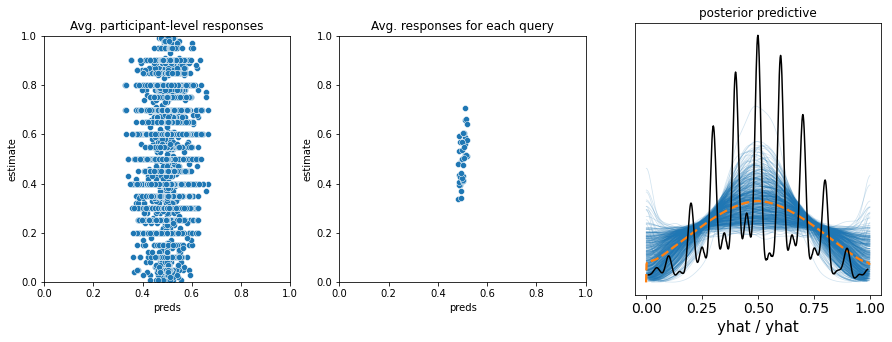

In [21]:
az_data_bs_noise_free = make_arviz_data(mcmc_bs_noise_free2, bs_complex_mlm_freenoise_d, X_data) # see model_helpers.py

plot_model_preds(df, az_data_bs_noise_free)

In [18]:
exp2_model_comparison = az.compare(
    {
        "BS complex mlm": az_data_bs, 
        "BS complex mlm noise": az_data_bs_noise,
        "BS complex mlm noise free": az_data_bs_noise_free,
    }, 
    scale="deviance", ic="loo")

exp2_model_comparison

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated sh

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BS complex mlm noise free,0,-2431.206476,451.158658,0.000000,0.742123,80.442983,0.000000,True,deviance
BS complex mlm noise,1,-2383.296678,420.770112,47.909799,0.104011,72.739995,25.806687,True,deviance
BS complex mlm,2,-2082.104474,365.116963,349.102002,0.153866,82.734960,58.112060,True,deviance


In [49]:

def posterior_to_df_1d(az_data, var_name):
    z = az_data.stack(sample=['chain','draw'])
    x = pd.DataFrame(np.array(z.posterior[var_name]))
    z = x.reset_index() >> s.gather("draw", "value", -_.index)
    
    return(z)

def posterior_to_df_2d(az_data, var_name1, var_name2):
    z = az_data.stack(sample=['chain','draw'])
    x1 = pd.DataFrame(np.array(z.posterior[var_name1]))
    x1 = x1.reset_index() >> s.gather("draw", "value1", -_.index)
    
    
    x2 = pd.DataFrame(np.array(z.posterior[var_name2]))
    x2 = x2.reset_index() >> s.gather("draw", "value2", -_.index)
    
    x1["value2"] = x2.value2
    
    return(x1)


def extract_samples(z, var_name):
    x1 = pd.DataFrame(np.array(z.posterior[var_name]))
    x1 = x1.reset_index() >> s.gather("draw", "value", -_.index) >> s.mutate(var = var_name)
    
    return(x1)

def posterior_to_df_multi(az_data, var_list):
    # note variables must have same raw dimensions
    z = az_data.stack(sample=['chain','draw'])
    
    df_list = [extract_samples(z, v) for v in var_list]
    df = pd.concat(df_list)
    
    df = df >> s.spread("var", "value")
    
    return(df)



## -- old stuff

# my_azdata.posterior["N_prime"] = np.exp(my_azdata.posterior.N_prime_pop) + np.exp(my_azdata.posterior.N_prime_r)
# my_azdata.posterior["N_delta"] = np.exp(my_azdata.posterior.N_delta_pop) + np.exp(my_azdata.posterior.N_delta_r)


# posterior_to_df_multi(az_data_bs_noise_free, ["N_prime", "N_delta"])

# res

In [ ]:
## first thing, not much avg differnce btw N and N', need to see if it aligns with d and d'

my_azdata = az_data_bs_noise_free

res  = (
    posterior_to_df_multi(my_azdata, ["N_prime_pop" ,"N_delta_pop", "d_base_pop", "d_delta_pop"]) >>
    s.mutate(
        N_pop = 1 + np.exp(_.N_prime_pop) + np.exp(_.N_delta_pop),
        N_prime_pop = 1 + np.exp(_.N_prime_pop)
    )
)

# res.head()
ggplot(res, aes(x="N_delta_pop")) + geom_histogram()

this is still kind of quick'n'dirty but the population differences in d and d' do not match up with N and N' -- would expect bigger differences in N and N' given the differences in d and d' assuming beta is constant (as BS model should).

In [148]:
# not much difference btw N and N', is there as much as expected given differences in d and d'. So infer N from d. 
## first infer beta
## then infer N' based on beta and d' and compute N-N'
## compare with observed N_delta_pop

##

from scipy.special import expit

res  = (
    posterior_to_df_multi(my_azdata, ["N_prime_pop" ,"N_delta_pop", "d_base_pop", "d_delta_pop"]) >>
    s.mutate(
        d_base_pop = expit(_.d_base_pop)/2.,
        d_prime_pop = expit(_.d_base_pop + np.exp(_.d_delta_pop))/2.,
        N_pop = 1 + np.exp(_.N_prime_pop) + np.exp(_.N_delta_pop),
        N_prime_pop = 1 + np.exp(_.N_prime_pop),
        beta = _.N_pop / (1./ _.d_base_pop - 2),
        N_prime_pred = (_.beta - 2.*_.beta*_.d_prime_pop)/_.d_prime_pop,
        N_delta_pred = _.N_pop - _.N_prime_pred,
        N_delta_pop = _.N_pop - _.N_prime_pop
    ) >>
    s.gather("var", "val", _.N_delta_pred, _.N_delta_pop) >>
    s.group_by(_.var) >>
    s.summarize(
        M = _.val.mean(),
        ul = _.val.quantile(.975),
        ll = _.val.quantile(.025)
    )
)

# ggplot(res, aes("N_delta_pred", "N_delta_pop")) + geom_point() + geom_smooth() + theme(aspect_ratio=1) + xlim(0,6) + ylim(0,6)

res

,var,M,ul,ll
0,N_delta_pop,0.768406,1.224977,0.394274
1,N_delta_pred,2.644878,3.896398,1.258516


Backed-out beta is correlated with N, but shouldn't be under the BS model. Also the implied beta values are quite high! Average N values are similar to those estimated in Sundh et al. 2021, but that hides substantial variation across Ps, with some much higher.

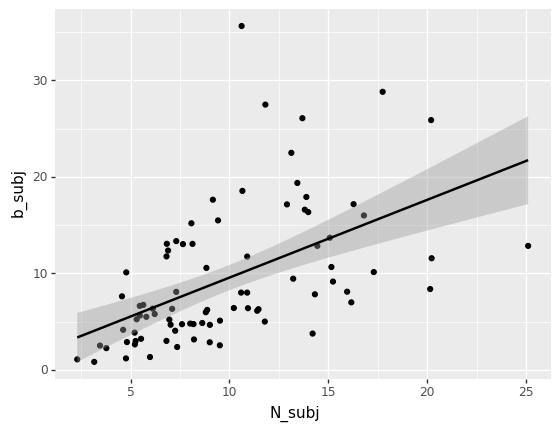

<ggplot: (8788146723024)>

In [149]:
res = posterior_to_df_multi(my_azdata, ["d_subj", "N_subj", "N_prime_subj", "d_prime_subj"])

res = (
res >>
    s.group_by(_.index) >>
    s.summarize(
        d_subj = _.d_subj.mean(),
        N_subj = _.N_subj.mean(),
        d_prime_subj = _.d_prime_subj.mean(),
        N_prime_subj = _.N_prime_subj.mean(),
    )
)

(res >> 
    s.mutate(b_subj = _.N_subj/(1/_.d_subj - 2.) ) >>
    ggplot(aes("N_subj", "b_subj")) + geom_point() + geom_smooth(method="lm")
)

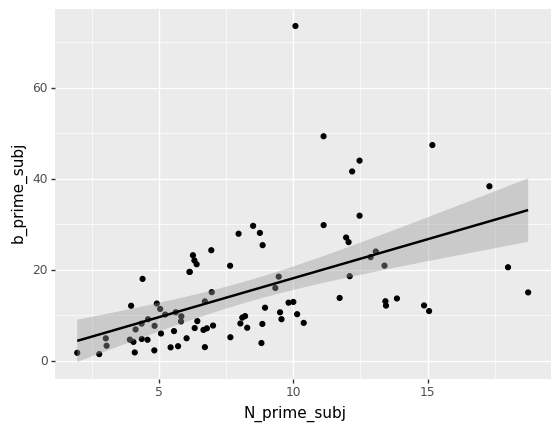

<ggplot: (8788109287982)>

In [150]:
(res >> 
    s.mutate(b_prime_subj = _.N_prime_subj/(1/_.d_prime_subj - 2.) ) >>
    ggplot(aes("N_prime_subj", "b_prime_subj")) + geom_point() + geom_smooth(method="lm")
)

0.017604119801123645


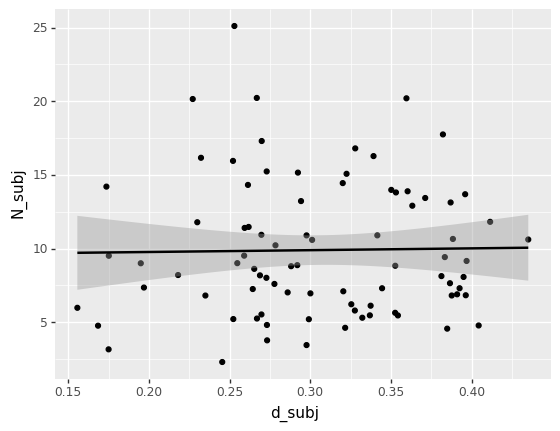

<ggplot: (8788153782745)>

In [151]:
print(res.d_subj.corr(res.N_subj))
(res >> 
    ggplot(aes("d_subj","N_subj")) + geom_point() + geom_smooth(method="lm")
)

0.0841466415000584


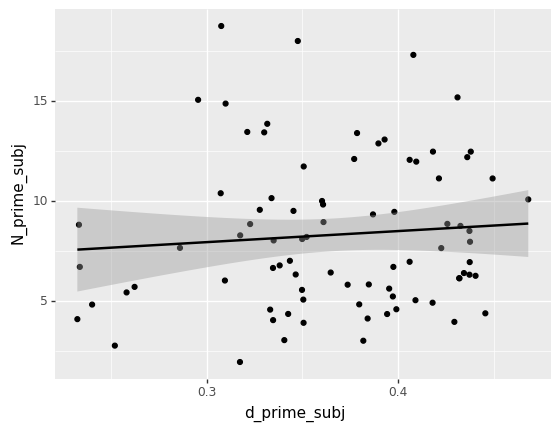

<ggplot: (8788164469182)>

In [152]:
print(res.d_prime_subj.corr(res.N_prime_subj))

(res >> 
    ggplot(aes( "d_prime_subj", "N_prime_subj")) + geom_point() + geom_smooth(method="lm")
)

$d$ and $N$ are uncorrelated, which is what we'd expect under PT+N but not under BS. 

Overall, estimates are not too far out of line with other competing estimates. Compared to the wasserstein-distance-based fits, $N$ is smaller, and $d$ is in a similar range. Compared to estimates from Sundh et al. 2021, $N$ is comparable and $d$ is larger. But, Sundh et al. 2021 estimate for $d$ is likely biased--they estimate it only from variance and other sources of variance may be biasing it (e.g. typing errors, rounding, misunderstandings, attentional lapses, etc.). these other sources would ADD to overall variance which would decrease the value of the $\alpha$ intercept, which would lead to a smaller inferred $d$.

/opt/conda/lib/python3.8/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


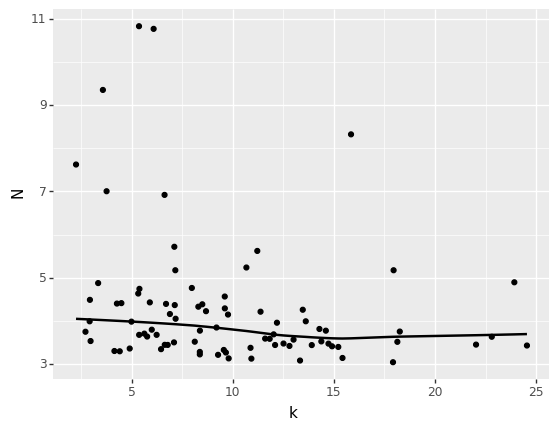

<ggplot: (8788296542501)>

In [11]:
from plotnine import *

res = (
posterior_to_df_multi(az_data_bs_noise_free, ["k", "N_prime", "N_delta"]) >> 
    s.mutate(N = _.N_prime + _.N_delta) >>
    s.group_by(_.index) >>
    s.summarize(N_prime = _.N_prime.mean(), N = _.N.mean(), k = _.k.mean())
    
)

ggplot(res, aes("k", "N")) + geom_point() + geom_smooth()

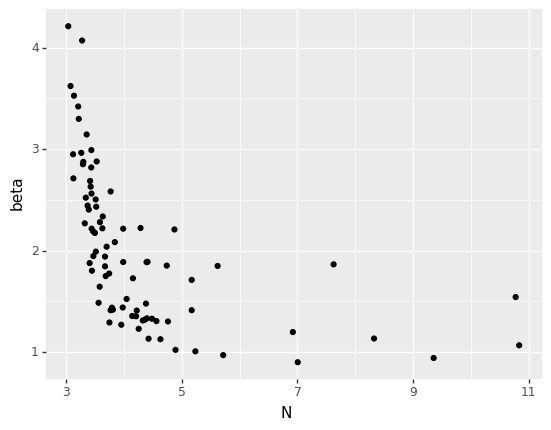

<ggplot: (8788234359001)>

In [19]:
import scipy

my_azdata = az_data_bs_noise_free

my_azdata.posterior["N_prime"] = np.exp(my_azdata.posterior.N_prime_pop) + np.exp(my_azdata.posterior.N_prime_r)
my_azdata.posterior["N_delta"] = np.exp(my_azdata.posterior.N_delta_pop) + np.exp(my_azdata.posterior.N_delta_r)
my_azdata.posterior["beta"] = my_azdata.posterior.beta_pop + my_azdata.posterior.beta_r

res = (
posterior_to_df_multi(my_azdata, ["beta", "N_prime", "N_delta"]) >> 
    s.mutate(N = _.N_prime + _.N_delta, beta = np.exp(_.beta)) >>
    s.group_by(_.index) >>
    s.summarize(N_prime = _.N_prime.mean(), N = _.N.mean(), beta = _.beta.mean()) >>
    s.filter(_.N < 25)
    
)

ggplot(res, aes("N", "beta")) + geom_point()

## 6/7/22, 5:20 PM interim conclusions

It's not looking all that good for the Bayesian Sampler model in these distributional regression analyses. Assuming that the number of samples is the noise parameter for the beta regression produces a much worse model. And it looks fairly clear that $k$ and $N$ are more or less uncorrelated when allowed to vary freely. 

The PT+N model assumes no correlation between noise and response noise. So this could argue for a noise-based model like PT+N (but without that model's extra non-Bayesian conditional probability bits). 

After some further explorations with less constrained $\beta$, things are looking less bad for the Bayesian Sampler but still fairly muddled. Now the "noise" model is better than the base model (!) but worse than the freely-varying noise model. And in the freely varying model there is no association between inferred avg samples and k.

In the noise model, $\beta$ and $N$, $N'$ are correlated in a way not predicted by the Bayesian Sampler model, and I'm getting quite large values of $\beta$ that seem outside the spirit of the Bayesian Sampler model. Basically, the high noise levels imply strong priors. 

The high noise levels are (apparently) also a bit of an issue for the PT+N model, as the authors' argued that $d$ values are not ever expected to be near .5.

## Time to implement rounding models

I think rounding may be throwing off the estimate of dispersion (as some of the dispersion is due to rounding), which in turn will affect estimates of $N$ and thus $\beta$. I'm not sure this will make things look better, but seems important to model.

I also need to more carefully think through whether this model is actually right. The BS model says you report the mean of your Beta distribution. So what is the disperion of that? pretty sure it's Beta because it comes from the variance in the binomial sampling, and Beta is like the continuous version of binomial.

i.e. logic is you have a mental model that produces samples with some true rate $\rho$, then from that you get some samples and have an observed fraction $r$ that you integrate with your prior to form a Beta distribution of which you report the mean, which is the response $y$ (ignoring rounding). So it's a beta-binomial-beta model. Except that last beta part is actualy fixed as we imagine people compute and reliably report the mean. So I think when you integrate out the binomial you just get a Beta again. Could simulate it I suppose to sanity-check this (did a quick check and appears yes).

In [87]:
# def binned_probs(mu, k, n_bins):

# dist.Beta(1,1).cdf(.5)

grad_betainc = jax.grad(jax.scipy.special.betainc)

grad_betainc(1.,1.,.2)


# print(jax.__version__)

ValueError: Betainc gradient with respect to a and b not supported.